In [1]:
from imageio import imread
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import cytoolz as cz
import tensorflow as tf
import functools
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
from skimage import exposure
import random
from data_downloader.data import Downloader

%matplotlib inline

In [2]:
data = Downloader('german-traffic-signs')

###################################################
Attempting to download: german-traffic-signs-dataset
###################################################
- Opening url: http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Training_Images.zip
- Progress: 100.00%
- Download Complete!
- Found and verified: german-traffic-signs-train.zip
- Extracting german-traffic-signs-train.zip
- Moving Files and built csv
- Removing unzip_folder

- Opening url: http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_Images.zip
- Progress: 100.00%
- Download Complete!
- Found and verified: german-traffic-signs-test.zip
- Extracting german-traffic-signs-test.zip
- Moving Files and built csv
- Removing unzip_folder

- Opening url: http://benchmark.ini.rub.de/Dataset/GTSRB_Final_Test_GT.zip
- Progress: 106.90%
- Download Complete!
- Found and verified: german-final-test.zip
- Extracting german-final-test.zip
- Moving Files and built csv


In [3]:
def load_data(path, df):
    df = pd.read_pickle(os.path.join(path, df))   
    return df

path = 'data/german-traffic-signs'

df_train = load_data(path, 'training-data.csv')
df_test = load_data(path, 'test-data.csv')

In [4]:
df_train.head()

,filename,width,height,roi.x1,roi.y1,roi.x2,roi.y2,class_id,image
574,/home/mauricio/Documents/tutoriales/german-tra...,33,33,5,5,28,28,2,"[[[120, 118, 45], [122, 89, 31], [216, 152, 88..."
572,/home/mauricio/Documents/tutoriales/german-tra...,33,33,5,5,28,28,2,"[[[159, 145, 53], [173, 112, 38], [250, 142, 6..."
195,/home/mauricio/Documents/tutoriales/german-tra...,31,34,5,5,26,29,34,"[[[59, 51, 50], [57, 54, 56], [44, 45, 49], [3..."
171,/home/mauricio/Documents/tutoriales/german-tra...,55,49,6,6,50,44,26,"[[[19, 17, 25], [17, 16, 22], [15, 14, 20], [1..."
852,/home/mauricio/Documents/tutoriales/german-tra...,36,42,6,6,31,37,1,"[[[255, 189, 189], [207, 173, 179], [217, 214,..."


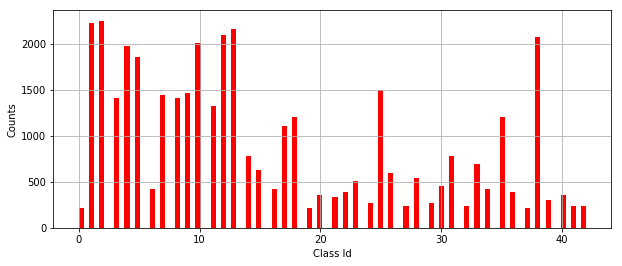

Dataset size:  39209


In [5]:
df = df_train.sample(frac=1)

plt.figure(figsize=(10,4))
df.class_id.hist(bins=100, color='r')
plt.xlabel('Class Id')
plt.ylabel('Counts')
plt.show()
print('Dataset size: ', len(df.class_id))

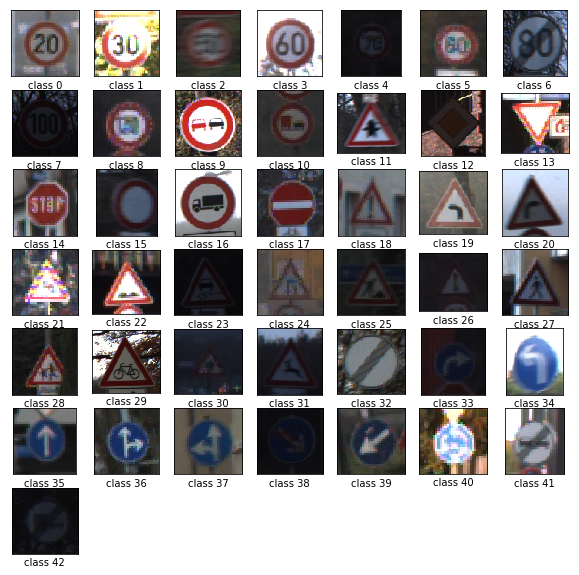

In [6]:
fig=plt.figure(figsize=(10, 10))
rows = 7
cols = 7

for i in range(1, 44):
    img = df.image[df['class_id']==i-1]
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(img[int(np.random.choice(range(len(img)), 1))])
    ax.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)   
    ax.set_xlabel('class {}'.format(i-1))
plt.show()

In [7]:
#data Augmentation

def flip_verticaly(image):
    return np.flipud(image)

def flip_horizontally(image):
    return np.fliplr(image)
    
def flip_both(image):
    image = flip_horizontally(image)
    return flip_verticaly(image)


def flip_images_augmentation(df, num_class):

    
    appended_data = []
    
    flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    flippable_vertically = np.array([1, 5, 12, 15, 17])
    flippable_both = np.array([32, 40])
    cross_class_id = np.array([[19, 20], [33, 34], 
                        [36, 37], [38, 39], 
                        [20, 19], [34, 33], 
                        [37, 36], [39, 38]])
    
    for c in range(43):
        
        if c in flippable_vertically:
            new_df = df[df.class_id == c]
            df.loc[:,'is_flipped'] = False
            new_df.loc[:,'is_flipped'] = True
            row_indexer = (new_df.class_id==c)
            new_df.loc[row_indexer, 'image'] = new_df[row_indexer].image.apply(flip_verticaly)
            appended_data.append(new_df)
            
        if c in flippable_horizontally:
#             print('flippable_horizontally {}'.format(c))
            new_df = df[df.class_id == c]
            df.loc[:,'is_flipped'] = False
            new_df.loc[:,'is_flipped'] = True
            row_indexer = (new_df.class_id==c)
            new_df.loc[row_indexer, 'image'] = new_df[row_indexer].image.apply(flip_horizontally)
            appended_data.append(new_df)
            
        elif c in flippable_both:
            new_df = df[df.class_id == c]
            df.loc[:,'is_flipped'] = False
            new_df.loc[:,'is_flipped'] = True
            row_indexer = (new_df.class_id==c)
            new_df.loc[row_indexer, 'image'] = new_df[row_indexer].image.apply(flip_both)
            appended_data.append(new_df)
            
        elif c in cross_class_id[:, 0]:
            new_df = df[df.class_id == c]
            df.loc[:,'is_flipped'] = False
            new_df.loc[:,'is_flipped'] = True
            row_indexer = (new_df.class_id==c)
            new_df.loc[row_indexer, 'image'] = new_df[row_indexer].image.apply(flip_horizontally)
            new_df.loc[row_indexer, 'class_id'] = new_df[row_indexer].class_id.apply(lambda x: cross_class_id[cross_class_id[:, 0] == x][0][1])
            appended_data.append(new_df)

    appended_data = pd.concat(appended_data, axis=0) 
    return pd.concat([df, appended_data])

/home/mauricio/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/mauricio/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


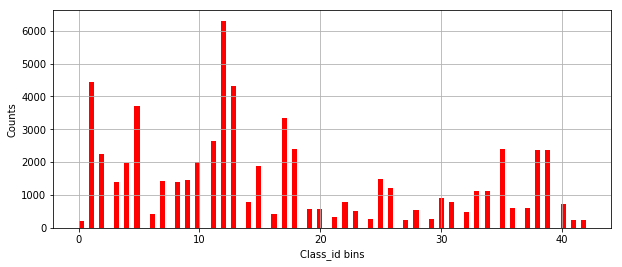

Current Dataset Size:  63538


In [8]:
augmented = flip_images_augmentation(df, 43)

plt.figure(figsize=(10, 4))
augmented.class_id.hist(bins=100, color='r')
plt.xlabel('Class_id bins')
plt.ylabel('Counts')
plt.show()
print("Current Dataset Size: ", len(augmented))

In [9]:
augmented.head(5)

,filename,width,height,roi.x1,roi.y1,roi.x2,roi.y2,class_id,image,is_flipped
862,/home/mauricio/Documents/tutoriales/german-tra...,55,56,6,6,50,51,17,"[[[22, 26, 21], [19, 20, 17], [35, 34, 19], [7...",False
749,/home/mauricio/Documents/tutoriales/german-tra...,58,58,6,6,53,53,7,"[[[31, 29, 31], [26, 26, 26], [26, 28, 28], [2...",False
391,/home/mauricio/Documents/tutoriales/german-tra...,30,32,5,6,25,27,9,"[[[136, 120, 102], [126, 103, 84], [156, 125, ...",False
1141,/home/mauricio/Documents/tutoriales/german-tra...,28,28,6,5,23,23,1,"[[[35, 31, 34], [28, 26, 30], [26, 25, 28], [3...",False
794,/home/mauricio/Documents/tutoriales/german-tra...,34,34,5,5,29,29,3,"[[[47, 49, 46], [47, 49, 45], [46, 49, 46], [4...",False


In [10]:
# rotation
def rotate_image(img, theta=18):
    r,c = img.shape[:-1]
    new_img = cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_REPLICATE)
    rows,cols = new_img.shape[:-1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),theta,1)
    new_img = cv2.warpAffine(new_img,M,(cols,rows))
    r0,c0 = round((rows-r)/2), round((cols-c)/2)
    return new_img[r0:r0+r, c0:c0+c]

# scaling
def scale_image(img, x_scale=0.85, y_scale=1.15) :
    r, c = img.shape[:-1]
    scaled_img = cv2.resize(img,None,fx=x_scale,fy=y_scale)
    new_img = cv2.copyMakeBorder(scaled_img,5,5,5,5,cv2.BORDER_REPLICATE)
    rows,cols = new_img.shape[:-1]
    r0,c0 = round((rows-r)/2), round((cols-c)/2)
    return new_img[r0:r0+r, c0:c0+c]

# translation
def translate_image(img, delta_x=2, delta_y=-2):
    r,c = img.shape[:-1]
    new_img = cv2.copyMakeBorder(img,5,5,5,5,cv2.BORDER_REPLICATE)
    rows,cols = new_img.shape[:-1]
    r0,c0 = round((rows-r)/2)+delta_y, round((cols-c)/2)-delta_x
    return new_img[r0:r0+r, c0:c0+c]

In [11]:
def random_transform(img) :
    new_img = img
    transform_list = [rotate_image, translate_image, scale_image]
    random.shuffle(transform_list)
    for transform in transform_list :
        new_img = transform(new_img)
    return new_img

In [12]:
def perturb_data(df, n):
    
    feature = []
    num_classes = 43
    
    for label in range(num_classes):
        
        n_fake = n-len(df[df['class_id']==label])
        if n_fake <= 0 : continue
        
        for j in range(n_fake):
            num = np.random.choice(len(df[df['class_id']==label]), replace=False, size=1)
            im = df[df['class_id']==label].image.iloc[int(num)]
            filename = df[df['class_id']==label].filename.iloc[int(num)]
            feature.append({'filename': filename, 'class_id': label, 'image': random_transform(im)})
            
    return pd.DataFrame(feature)

In [13]:
X_train_pert = perturb_data(augmented, 5000)

In [14]:
df_train = pd.concat([X_train_pert, augmented], sort=True)
df_train = df_train.sample(frac=1).reset_index()
df_train.head(5)

,index,class_id,filename,height,image,is_flipped,roi.x1,roi.x2,roi.y1,roi.y2,width
0,55933,19,/home/mauricio/Documents/tutoriales/german-tra...,NaN,"[[[15, 14, 13], [15, 14, 13], [15, 14, 13], [1...",NaN,NaN,NaN,NaN,NaN,NaN
1,657,14,/home/mauricio/Documents/tutoriales/german-tra...,141.0,"[[[114, 147, 139], [198, 207, 176], [255, 241,...",False,11.0,121.0,13.0,129.0,132.0
2,60467,20,/home/mauricio/Documents/tutoriales/german-tra...,NaN,"[[[13, 13, 18], [13, 13, 18], [13, 13, 18], [1...",NaN,NaN,NaN,NaN,NaN,NaN
3,248,11,/home/mauricio/Documents/tutoriales/german-tra...,49.0,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",False,6.0,48.0,5.0,44.0,53.0
4,89403,27,/home/mauricio/Documents/tutoriales/german-tra...,NaN,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",NaN,NaN,NaN,NaN,NaN,NaN


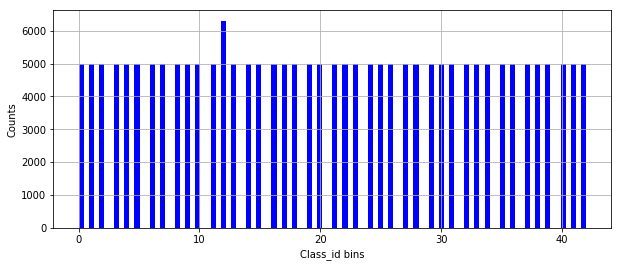

Current Dataset Size:  216300


In [15]:
plt.figure(figsize=(10, 4))
df_train.class_id.hist(bins=100, color='b')
plt.xlabel('Class_id bins')
plt.ylabel('Counts')
plt.show()
print("Current Dataset Size: ", len(df_train))

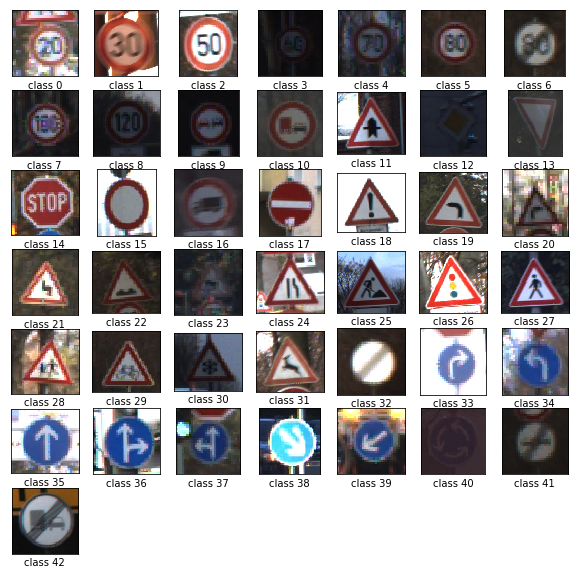

In [16]:
fig=plt.figure(figsize=(10, 10))
rows = 7
cols = 7

for i in range(1, 44):
    img = df.image[df['class_id']==i-1]
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(img[int(np.random.choice(range(len(img)), 1))])
    ax.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)   
    ax.set_xlabel('class {}'.format(i-1))
plt.show()

In [17]:
# Training Parameters
learning_rate = 0.0001
num_steps = 0
batch_size = 64
epochs = 5

# Network Parameters
num_classes = 43 
dropout = 0.25

In [18]:
# Neural Network
def conv_net(features, labels, mode):
    
    print()
    print("#######################")
    print("Model")
    print("#######################")
    
    input_layer = tf.reshape(features["image"], [-1, 32, 32, 3]);print(input_layer)

    conv1 = tf.layers.conv2d(input_layer, 32, 5, activation=tf.nn.relu); print(conv1)
    pool1 = tf.layers.max_pooling2d(conv1, 2, 2, padding='same'); print(pool1)

    conv2 = tf.layers.conv2d(pool1, 64, 5, activation=tf.nn.relu); print(conv2)
    pool2 = tf.layers.max_pooling2d(conv2, 2, 2, padding='same'); print(pool2)
    
    conv3 = tf.layers.conv2d(pool2, 128, 5, activation=tf.nn.relu); print(conv3)
    pool3 = tf.layers.max_pooling2d(conv3, 2, 2, padding='same'); print(pool3)

    # Flatten the data to a 1-D vector for the fully connected layer
    pool2_flat = tf.contrib.layers.flatten(pool3); print(pool2_flat)

    #fully connected layer
    dense = tf.layers.dense(pool2_flat, 1024, activation=tf.nn.relu); print(dense)

    #dropout
    fc1 = tf.layers.dropout(dense, rate=dropout, training=mode == tf.estimator.ModeKeys.TRAIN); print(fc1)
    logits = tf.layers.dense(fc1, units=num_classes); print(logits)
    print("#######################")
    print()


    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=num_classes)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logits)

    # Configure the Training Op
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [19]:
model = tf.estimator.Estimator(model_fn=conv_net, 
        model_dir="models/german")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/german', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd68a88a898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [20]:
def reshape_image(img, width, height):
    img = cv2.resize(img, (width, height))
    return img

def rgb2gray(image):
    r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
    image = 0.2989 * r + 0.5870 * g + 0.1140 * b
    image = (image / 255.).astype(np.float32)
    return image

def batch_df(df, batch_size=64, epochs=epochs):
    for epoch in range(epochs):
        for start in range(0, df.shape[0], batch_size):
            df_subset = df.iloc[start:start + batch_size]
            if len(df_subset) == batch_size:
                image = np.array([reshape_image((df_subset.image.values)[i], 32, 32 ) for i in range(len(df_subset))])
                labels = df_subset['class_id'].values
                yield image, labels
            else:
                pass
        
def input_fn(df):
    dataset = tf.data.Dataset.from_generator(
        functools.partial(batch_df, df=df),
        (tf.float32, tf.float32),
        (tf.TensorShape([batch_size, 32, 32, 3]), tf.TensorShape([batch_size]))
    )
    features, labels = dataset.make_one_shot_iterator().get_next()
    return {'image': features}, labels

In [21]:
# Train the Model
model.train(input_fn=functools.partial(input_fn, df=df_train))

INFO:tensorflow:Calling model_fn.

#######################
Model
#######################
Tensor("Reshape:0", shape=(64, 32, 32, 3), dtype=float32)
Tensor("conv2d/Relu:0", shape=(64, 28, 28, 32), dtype=float32)
Tensor("max_pooling2d/MaxPool:0", shape=(64, 14, 14, 32), dtype=float32)
Tensor("conv2d_1/Relu:0", shape=(64, 10, 10, 64), dtype=float32)
Tensor("max_pooling2d_1/MaxPool:0", shape=(64, 5, 5, 64), dtype=float32)
Tensor("conv2d_2/Relu:0", shape=(64, 1, 1, 128), dtype=float32)
Tensor("max_pooling2d_2/MaxPool:0", shape=(64, 1, 1, 128), dtype=float32)
Tensor("Flatten/flatten/Reshape:0", shape=(64, 128), dtype=float32)
Tensor("dense/Relu:0", shape=(64, 1024), dtype=float32)
Tensor("dropout/dropout/mul:0", shape=(64, 1024), dtype=float32)
Tensor("dense_1/BiasAdd:0", shape=(64, 43), dtype=float32)
#######################

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tens

INFO:tensorflow:global_step/sec: 152.131
INFO:tensorflow:loss = 0.15206113, step = 7200 (0.657 sec)
INFO:tensorflow:global_step/sec: 156.316
INFO:tensorflow:loss = 0.13276756, step = 7300 (0.640 sec)
INFO:tensorflow:global_step/sec: 152.693
INFO:tensorflow:loss = 0.22449706, step = 7400 (0.655 sec)
INFO:tensorflow:global_step/sec: 152.068
INFO:tensorflow:loss = 0.29692382, step = 7500 (0.658 sec)
INFO:tensorflow:global_step/sec: 148.844
INFO:tensorflow:loss = 0.22892056, step = 7600 (0.672 sec)
INFO:tensorflow:global_step/sec: 142.167
INFO:tensorflow:loss = 0.35824865, step = 7700 (0.703 sec)
INFO:tensorflow:global_step/sec: 152.264
INFO:tensorflow:loss = 0.31428418, step = 7800 (0.657 sec)
INFO:tensorflow:global_step/sec: 157.122
INFO:tensorflow:loss = 0.10450469, step = 7900 (0.636 sec)
INFO:tensorflow:global_step/sec: 157.136
INFO:tensorflow:loss = 0.55124015, step = 8000 (0.636 sec)
INFO:tensorflow:global_step/sec: 156.794
INFO:tensorflow:loss = 0.22528787, step = 8100 (0.638 sec)


INFO:tensorflow:global_step/sec: 155
INFO:tensorflow:loss = 0.23642385, step = 15400 (0.645 sec)
INFO:tensorflow:global_step/sec: 157.896
INFO:tensorflow:loss = 0.22996095, step = 15500 (0.633 sec)
INFO:tensorflow:global_step/sec: 156.086
INFO:tensorflow:loss = 0.31717062, step = 15600 (0.641 sec)
INFO:tensorflow:global_step/sec: 153.693
INFO:tensorflow:loss = 0.45996338, step = 15700 (0.651 sec)
INFO:tensorflow:global_step/sec: 153.931
INFO:tensorflow:loss = 0.27397612, step = 15800 (0.650 sec)
INFO:tensorflow:global_step/sec: 152.537
INFO:tensorflow:loss = 0.16552523, step = 15900 (0.655 sec)
INFO:tensorflow:global_step/sec: 156.948
INFO:tensorflow:loss = 0.1127004, step = 16000 (0.637 sec)
INFO:tensorflow:global_step/sec: 155.223
INFO:tensorflow:loss = 0.168024, step = 16100 (0.644 sec)
INFO:tensorflow:global_step/sec: 158.038
INFO:tensorflow:loss = 0.34371036, step = 16200 (0.633 sec)
INFO:tensorflow:global_step/sec: 154.541
INFO:tensorflow:loss = 0.2348269, step = 16300 (0.647 sec

In [22]:
# Evaluate the Model
model.evaluate(input_fn=functools.partial(input_fn, df=df_test))

INFO:tensorflow:Calling model_fn.

#######################
Model
#######################
Tensor("Reshape:0", shape=(64, 32, 32, 3), dtype=float32)
Tensor("conv2d/Relu:0", shape=(64, 28, 28, 32), dtype=float32)
Tensor("max_pooling2d/MaxPool:0", shape=(64, 14, 14, 32), dtype=float32)
Tensor("conv2d_1/Relu:0", shape=(64, 10, 10, 64), dtype=float32)
Tensor("max_pooling2d_1/MaxPool:0", shape=(64, 5, 5, 64), dtype=float32)
Tensor("conv2d_2/Relu:0", shape=(64, 1, 1, 128), dtype=float32)
Tensor("max_pooling2d_2/MaxPool:0", shape=(64, 1, 1, 128), dtype=float32)
Tensor("Flatten/flatten/Reshape:0", shape=(64, 128), dtype=float32)
Tensor("dense/Relu:0", shape=(64, 1024), dtype=float32)
Tensor("dropout/Identity:0", shape=(64, 1024), dtype=float32)
Tensor("dense_1/BiasAdd:0", shape=(64, 43), dtype=float32)
#######################

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-06-23:06:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters

{'accuracy': 0.9337722, 'loss': 0.4893365, 'global_step': 16895}

In [24]:
predictions = model.predict(input_fn=functools.partial(input_fn, df=df_predict))

In [ ]:
cls_pred = list(predictions)
cls_pred